###Import Library

In [ ]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display
from librosa.util import normalize as normalize

import numpy as np
import pandas as pd

import IPython.display as ipd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras import backend as K
#from keras.layers.normalization import BatchNormalization
import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
mypath = "/content/drive/MyDrive/Vocal Dataset"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 
filepaths = [join(mypath, f) for f in filenames] 

###Data Labelling

In [ ]:
import os

labels = []
l1, l2, l3, l4, l5 = [], [], [], [], []
for filename in os.listdir(mypath):
    if filename.endswith('.wav'):
      label = filename.split('_')[0]
      labels.append(label)
      l1.append(label)
for filename in os.listdir(mypath+'/Expansion'):
    if filename.endswith('.wav'):
      label = filename.split('_')[0]
      labels.append(label)
      l2.append(label)
for filename in os.listdir(mypath+'/Augmentation'):
    if filename.endswith('.wav'):
      label = filename.split('_')[0]
      labels.append(label)
      l3.append(label)
for filename in os.listdir(mypath+'/Augmentation2'):
    if filename.endswith('.wav'):
      label = filename.split('_')[0]
      labels.append(label)
      l4.append(label)
for filename in os.listdir(mypath+'/Augmentation3'):
    if filename.endswith('.wav'):
      label = filename.split('_')[0]
      labels.append(label)
      l5.append(label)

####One Hot Encode Labels

In [ ]:
len(labels)

8523

In [ ]:
labelencoder = LabelEncoder()
i_labels = labelencoder.fit_transform(labels)
oh_labels = to_categorical(i_labels) 

###STFT

In [ ]:
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames

In [ ]:
%cd /content/drive/MyDrive/Vocal Dataset

/content/drive/MyDrive/Vocal Dataset


Spectogram Array Shape: (1025, 87)


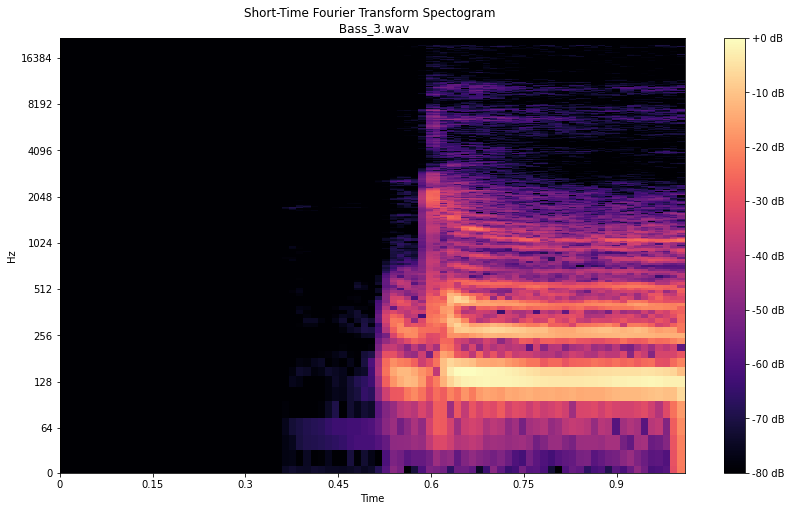

In [ ]:
# STFT Example
y, sr = librosa.load(filenames[10], sr=fs, duration=1)
y/=y.max() #Normalize
duration_in_samples=librosa.time_to_samples(1, sr=fs)
y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad to 1s if smaller
y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
y_spec=librosa.amplitude_to_db(abs(y_stft), np.max)
plt.figure(figsize=(14,8))
plt.title("Short-Time Fourier Transform Spectogram \n %s"%filenames[0])
librosa.display.specshow(y_spec,sr=fs,y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB');
print("Spectogram Array Shape:",y_spec.shape)
ipd.Audio(y, rate=fs)

In [ ]:
def featureGenerator(files):
    while True:
        for i,f in enumerate(files):
            try:
                feature_vectors = []
                y, sr = librosa.load(f, sr=fs)
                if len(y) < 2:
                    print("Error loading %s" % f)
                    continue
                y, index = librosa.effects.trim(y,top_db=60) #Trim
                y = normalize(y)
                duration_in_samples=librosa.time_to_samples(1, sr=fs)
                y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad/Trim to same duration
                y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
                y_spec=librosa.amplitude_to_db(abs(y_stft), np.min)
                scaler = StandardScaler()
                dtype = K.floatx()
                data = scaler.fit_transform(y_spec).astype(dtype)
                data = np.expand_dims(data, axis=0)
                data = np.expand_dims(data, axis=3)
                feature_vectors.append(data)
                return feature_vectors
            except Exception as e:
                print("Error loading %s. Error: %s" % (f,e))
                raise
                break

In [ ]:
def stftextractor(file_name):
  try:
    y, sr = librosa.load(file_name, sr=fs)
    y, index = librosa.effects.trim(y,top_db=60)
    y = normalize(y)
    duration_in_samples=librosa.time_to_samples(1, sr=fs)
    y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad/Trim to same duration
    y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
    y_spec=librosa.amplitude_to_db(abs(y_stft), np.min)
    scaler = StandardScaler()
    dtype = K.floatx()
    data = scaler.fit_transform(y_spec).astype(dtype)
    #data = np.expand_dims(data, axis=0)
    data = np.expand_dims(data, axis=2)
    return data
  except Exception as e:
    print("Error loading %s. Error: %s" % (file_name,e))
    raise

####Feature Extraction for Each Audio Files

In [ ]:
filenames2 = [f for f in listdir(mypath+'/Augmentation') if (isfile(join(mypath+'/Augmentation', f)) and f.endswith('.wav'))] 
filepaths2 = [join(mypath+'/Augmentation', f) for f in filenames2]
filenames3 = [f for f in listdir(mypath+'/Augmentation2') if (isfile(join(mypath+'/Augmentation2', f)) and f.endswith('.wav'))] 
filepaths3 = [join(mypath+'/Augmentation2', f) for f in filenames3]
filenames4 = [f for f in listdir(mypath+'/Expansion') if (isfile(join(mypath+'/Expansion', f)) and f.endswith('.wav'))] 
filepaths4 = [join(mypath+'/Expansion', f) for f in filenames4]
filenames5 = [f for f in listdir(mypath+'/Augmentation3') if (isfile(join(mypath+'/Augmentation3', f)) and f.endswith('.wav'))] 
filepaths5 = [join(mypath+'/Augmentation3', f) for f in filenames5]

In [ ]:
len(filepaths3)

2640

In [ ]:
audiodata = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    audiodata.append(file_name)

for file_name in filepaths2:
    audiodata.append(file_name)

for file_name in filepaths3:
    audiodata.append(file_name)

for file_name in filepaths4:
    audiodata.append(file_name)

for file_name in filepaths5:
    audiodata.append(file_name)

In [ ]:
len(audiodata) 

8523

In [ ]:
feature_vectors = []
for data in audiodata:
  feature_vectors.append(stftextractor(data))

In [ ]:
features = np.array(feature_vectors)

In [ ]:
features.shape

(8523, 1025, 87, 1)

In [ ]:
np.save('stft_features.npy', features)

In [ ]:
features = np.load('/content/drive/MyDrive/Vocal Dataset/stft_features.npy')

In [ ]:
features[0].shape

(1025, 87, 1)

In [ ]:
arr_reshaped = features.reshape(features.shape[0], -1) 

In [ ]:
unique_elements, counts_elements = np.unique(labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Alto' 'Bass' 'Sopran' 'Tenor']
 ['1777' '1851' '3225' '1670']]


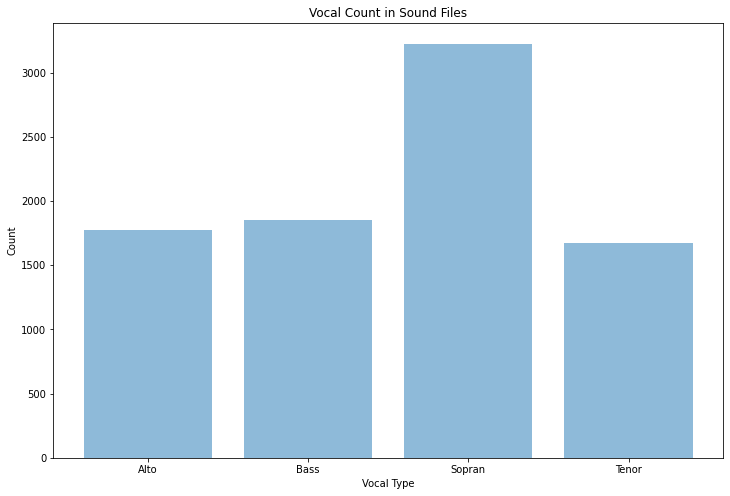

In [ ]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Vocal Type')
plt.title('Vocal Count in Sound Files')
plt.show()

###Split Training and Testing Data

In [ ]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = None)

###CNN

####Create Model

In [ ]:
from tensorflow.keras.optimizers import SGD

num_rows = 1025
num_columns = 87
num_channels = 1

opt = 'adam'
#opt = SGD(lr=0.009, momentum=0.9)
num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt) 

In [ ]:
# Display model architecture summary  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 86, 16)      80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 43, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 512, 43, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 511, 42, 32)       2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 255, 21, 32)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 255, 21, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 20, 64)       8

####Training Model

In [ ]:
# train model
num_epochs = 100
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=5),
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
54/54 [==============================] - 429s 8s/step - loss: 1.2008 - accuracy: 0.4661 - val_loss: 1.0736 - val_accuracy: 0.5361

Epoch 00001: val_accuracy improved from -inf to 0.53607, saving model to mymodel2_01.h5
Epoch 2/100
54/54 [==============================] - 403s 7s/step - loss: 1.0360 - accuracy: 0.5346 - val_loss: 1.1043 - val_accuracy: 0.4827

Epoch 00002: val_accuracy did not improve from 0.53607
Epoch 3/100
54/54 [==============================] - 402s 7s/step - loss: 0.9871 - accuracy: 0.5540 - val_loss: 1.1104 - val_accuracy: 0.4997

Epoch 00003: val_accuracy did not improve from 0.53607
Epoch 4/100
54/54 [==============================] - 405s 8s/step - loss: 0.9500 - accuracy: 0.5823 - val_loss: 1.0028 - val_accuracy: 0.5519

Epoch 00004: val_accuracy improved from 0.53607 to 0.55191, saving model to mymodel2_04.h5
Epoch 5/100
54/54 [==============================] - 405s 8s/step - loss: 0.9288 - accuracy: 0.5833 - val_loss: 1.0924 - val_accuracy: 0.50

####Evaluate Model

In [ ]:
score = model.evaluate(x_train, y_train, verbose=5)
print("Training Accuracy: ", score[1] * 100,'%')    

score = model.evaluate(x_test, y_test, verbose=5)
print("Testing Accuracy: ", score[1] * 100, '%')  

In [ ]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes
        
n_classes=4 # number of classes

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
c_names = ['Tenor', 'Bass', 'Sopran', 'Alto']

In [ ]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05]) 
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [ ]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

In [ ]:
# Confusion Matrix 
print(confusion_matrix(y_testclass, classpreds))

In [ ]:
print('Macro Precision: {:.2f}'.format(precision_score(y_testclass, classpreds, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_testclass, classpreds, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_testclass, classpreds, average='macro')))